<a href="https://colab.research.google.com/github/raffieeey/MasterResearchAutoML/blob/master/h2oautoml/02A_H2OAutoml_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependecies for H2O automl

In [43]:
!pip install pmlb
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install pytictoc

In [0]:
#!pip uninstall h2o -y

## Installing H2O

In [45]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


## Getting the number of Cores

In [46]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

##Starting H2O

In [0]:
import h2o

In [48]:
h2o.init(nthreads=2,
                 min_mem_size="2048M",
                 max_mem_size="2048M")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 7 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_unknownUser_dw0zg7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.537 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Creating the metrics for AUC and AUCpr (Binary classification)

In [49]:
%matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np



def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate","True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate","True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall","Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = (np.sum(labels)/len(labels))[0]
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall","Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

figure()

<Figure size 648x324 with 0 Axes>

## Creating all the metrics for Classification algorithm

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss
import numpy as np
import pandas as pd


class CheckBinomial:
  def __init__(self, checkunique):
    self._bintype = 'binomial' if pd.Series(checkunique).nunique() == 2 else 'multinomial'

  def MLMetrics(self):
    if self._bintype == 'binomial':
      return ['mean_per_class_error', 'AUC', 'logloss']
    elif self._bintype == 'multinomial':
      return ['mean_per_class_error', 'logloss']

class MetricsCalc:
  def __init__(self, truth, predictions):
    self.truth = truth.as_data_frame()
    self.predictions = predictions
    self._target = predictions.iloc[:,0]
    self._probabmax = np.max(predictions.iloc[:,1:], axis=1)
    self._probab = predictions.iloc[:,1:]
    self._type = 'binomial' if (self.truth.nunique() == 2).bool() else 'multinomial'

  def acc(self):
    return float(accuracy_score(self.truth,self._target))

  def auc(self):
    if self._type == "binomial":
      return float(roc_auc_score(self.truth, self._probabmax))
    elif self._type == "multinomial":
      return np.nan 

  def logloss(self):
    return float(log_loss(self.truth, self._probab))
  
  def cm(self):
    return confusion_matrix(self.truth, self._target)
  
  def f1(self):
    if self._type == "binomial":
      return float(f1_score(self.truth, self._target, average='binary'))
    elif self._type == "multinomial":
      return float(f1_score(self.truth, self._target, average='macro')) 

## Running H2O autoML with 
- 120 seconds
- Seed 69
- 2 Cores
- 2GB memory

- Tested for metrics: 
> - Mean per class error
> - AUC
> - Logloss

- Recorded for metrics: 
> - Mean per class error
> - AUC
> - Logloss
> - F1 score
> - Confusion Metrics

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 127.042219 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,auc,logloss,aucpr,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200523_154126,0.216036,0.922412,0.301955,0.972943,0.305248,0.0931764
XGBoost_grid__1_AutoML_20200523_154126_model_1,0.220643,0.923941,0.286046,0.974075,0.301493,0.090898
StackedEnsemble_AllModels_AutoML_20200523_154126,0.226773,0.922874,0.299996,0.973077,0.304725,0.0928573
GBM_4_AutoML_20200523_154126,0.234346,0.906576,0.440148,0.964349,0.372607,0.138836
XGBoost_2_AutoML_20200523_154126,0.238856,0.911134,0.343458,0.967438,0.319513,0.102088



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_154126_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_4_AutoML_20200523_154126',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XRT_1_AutoML_20200523_154126',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                     

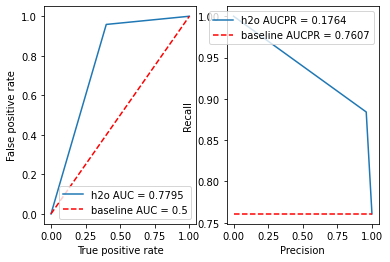

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 126.710108 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20200523_154336_model_1,0.923713,0.286462,0.973966,0.22775,0.301706,0.0910263
StackedEnsemble_BestOfFamily_AutoML_20200523_154336,0.922893,0.301713,0.97335,0.224096,0.305263,0.0931856
StackedEnsemble_AllModels_AutoML_20200523_154336,0.922831,0.300087,0.973151,0.226524,0.304814,0.0929117
GBM_grid__1_AutoML_20200523_154336_model_1,0.917461,0.321652,0.970664,0.241664,0.313213,0.0981023
XGBoost_3_AutoML_20200523_154336,0.912109,0.319327,0.968612,0.253924,0.313723,0.0984222



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'bernoulli',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XGBo

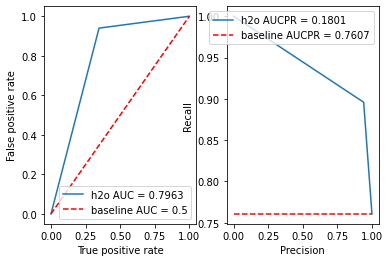

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 125.821259 seconds.
*** Top algorithm: *** 

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20200523_154546_model_1,0.286439,0.923695,0.973911,0.22314,0.301683,0.0910127
StackedEnsemble_AllModels_AutoML_20200523_154546,0.299774,0.922718,0.973103,0.225251,0.304737,0.0928644
StackedEnsemble_BestOfFamily_AutoML_20200523_154546,0.301206,0.922827,0.973392,0.223288,0.305137,0.0931083
XGBoost_3_AutoML_20200523_154546,0.321249,0.911707,0.968278,0.249003,0.31427,0.0987659
GBM_grid__1_AutoML_20200523_154546_model_1,0.321266,0.917513,0.970642,0.240436,0.31306,0.0980065



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'bernoulli',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XGBo

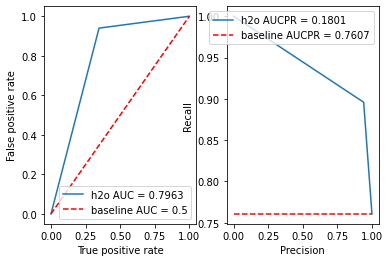

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 125.181983 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_2_AutoML_20200523_155001,1,0.107958,1,0,0.110742,0.0122638
XGBoost_grid__1_AutoML_20200523_155001_model_2,1,0.00429563,1,0,0.0159072,0.000253039
StackedEnsemble_BestOfFamily_AutoML_20200523_155001,1,0.00261393,1,0,0.00604559,3.65492e-05
DRF_1_AutoML_20200523_155001,1,0.000228762,1,0,0.00460743,2.12284e-05
XGBoost_1_AutoML_20200523_155001,1,0.00769841,1,0,0.023942,0.00057322



{'balance_classes': False,
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'check_constant_response': True,
 'checkpoint': None,
 'class_sampling_factors': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_change_per_level': 1.0,
 'col_sample_rate_per_tree': 0.8,
 'custom_distribution_func': None,
 'custom_metric_func': None,
 'distribution': 'bernoulli',
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'histogram_type': 'AUTO',
 'huber_alpha': 0.9,
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.1,
 'learn_rate_annealing': 1.0,
 'max_abs_leafnode_pred': 1.7976931348623157e+308,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_depth': 7,
 'max_hit_ratio_k': 0,
 'max_runtime_secs': 0.0,
 'min_rows': 10.0,


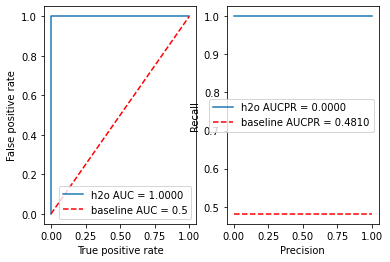

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 125.013338 seconds.
*** Top algorithm: *** 

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
DRF_1_AutoML_20200523_155208,0.000366285,1,1,0,0.00384978,1.48208e-05
GBM_grid__1_AutoML_20200523_155208_model_1,0.00123845,1,1,0,0.00515236,2.65468e-05
StackedEnsemble_AllModels_AutoML_20200523_155208,0.00145895,1,1,0,0.00369167,1.36285e-05
StackedEnsemble_BestOfFamily_AutoML_20200523_155208,0.00229945,1,1,0,0.00373822,1.39743e-05
XGBoost_grid__1_AutoML_20200523_155208_model_1,0.00231687,1,1,0,0.00818208,6.69464e-05



{'balance_classes': False,
 'binomial_double_trees': False,
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'check_constant_response': True,
 'checkpoint': None,
 'class_sampling_factors': None,
 'col_sample_rate_change_per_level': 1.0,
 'col_sample_rate_per_tree': 1.0,
 'custom_metric_func': None,
 'distribution': 'multinomial',
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'histogram_type': 'AUTO',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_depth': 20,
 'max_hit_ratio_k': 0,
 'max_runtime_secs': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 1e-05,
 'model_id': 'DRF_1_AutoML_20200523_155208',
 'mtries': -1,
 'nbins': 20,
 'nbins_cats': 1024,
 'nbins_top_level':

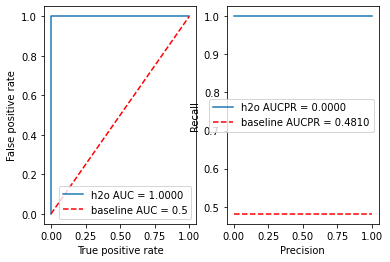

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 124.903984 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,auc,logloss,aucpr,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200523_155415,0.0946204,0.914492,0.140398,0.878005,0.18337,0.0336246
XGBoost_grid__1_AutoML_20200523_155415_model_4,0.0992177,0.917789,0.150316,0.876746,0.188059,0.0353662
StackedEnsemble_AllModels_AutoML_20200523_155415,0.0992275,0.915427,0.136626,0.881393,0.180286,0.0325031
XGBoost_3_AutoML_20200523_155415,0.100512,0.917677,0.156853,0.874702,0.191236,0.0365711
XGBoost_grid__1_AutoML_20200523_155415_model_1,0.101308,0.912648,0.163637,0.871107,0.193865,0.0375837



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_155415_model_4',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_3_AutoML_20200523_155415',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DRF_1_AutoML_20200523_155415',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                     

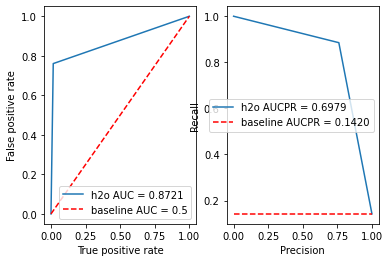

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 125.434380 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20200523_155622,0.919958,0.1598,0.871867,0.112612,0.194947,0.0380042
XGBoost_3_AutoML_20200523_155622,0.917944,0.157034,0.874238,0.099855,0.191443,0.0366504
StackedEnsemble_BestOfFamily_AutoML_20200523_155622,0.917433,0.139032,0.880707,0.10067,0.18189,0.033084
XGBoost_grid__1_AutoML_20200523_155622_model_3,0.917025,0.175323,0.866952,0.116902,0.205569,0.0422587
GBM_4_AutoML_20200523_155622,0.91654,0.192975,0.871526,0.125459,0.219152,0.0480275



{'balance_classes': False,
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'check_constant_response': True,
 'checkpoint': None,
 'class_sampling_factors': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_change_per_level': 1.0,
 'col_sample_rate_per_tree': 0.8,
 'custom_distribution_func': None,
 'custom_metric_func': None,
 'distribution': 'bernoulli',
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'histogram_type': 'AUTO',
 'huber_alpha': 0.9,
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.1,
 'learn_rate_annealing': 1.0,
 'max_abs_leafnode_pred': 1.7976931348623157e+308,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_depth': 6,
 'max_hit_ratio_k': 0,
 'max_runtime_secs': 0.0,
 'min_rows': 1.0,
 

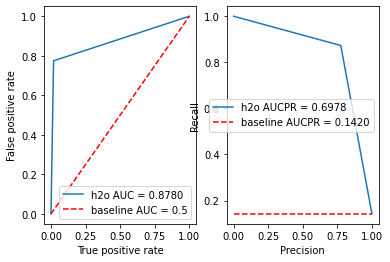

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 125.529090 seconds.
*** Top algorithm: *** 

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200523_155829,0.137109,0.914422,0.880494,0.0951478,0.180568,0.0326049
StackedEnsemble_BestOfFamily_AutoML_20200523_155829,0.139161,0.916085,0.880499,0.10475,0.182126,0.0331699
XGBoost_3_AutoML_20200523_155829,0.156258,0.917698,0.874829,0.098412,0.191107,0.036522
XGBoost_grid__1_AutoML_20200523_155829_model_4,0.162265,0.920643,0.871261,0.113767,0.196222,0.038503
GBM_1_AutoML_20200523_155829,0.162428,0.918856,0.870581,0.114841,0.196605,0.0386537



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_3_AutoML_20200523_155829',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_155829_model_4',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_1_AutoML_20200523_155829',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                 

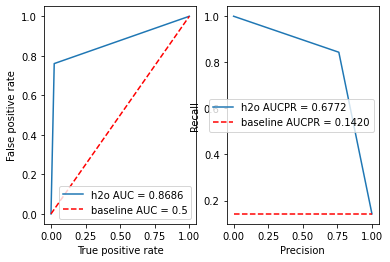

________________________________________________________________________________
*** Dataset Name: nursery ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 192.883891 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20200523_160037_model_1,0.0120624,0.0470664,0.0886869,0.00786537
StackedEnsemble_BestOfFamily_AutoML_20200523_160037,0.0124165,0.013707,0.0513985,0.00264181
StackedEnsemble_AllModels_AutoML_20200523_160037,0.0136618,0.0135691,0.052289,0.00273414
DRF_1_AutoML_20200523_160037,0.037351,0.127389,0.139232,0.0193855
XGBoost_1_AutoML_20200523_160037,0.0848098,0.167376,0.194272,0.0377415



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'multinomial',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XG

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20200523_160352_model_1,0.0137574,0.0476671,0.0894822,0.00800707
StackedEnsemble_BestOfFamily_AutoML_20200523_160352,0.0146395,0.0139582,0.0528047,0.00278834
StackedEnsemble_AllModels_AutoML_20200523_160352,0.0156208,0.0138755,0.0535341,0.0028659
DRF_1_AutoML_20200523_160352,0.0312993,0.104265,0.134817,0.0181756
XGBoost_1_AutoML_20200523_160352,0.0848098,0.167376,0.194272,0.0377415



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'multinomial',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XG

model_id,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200523_160702,0.0136585,0.0135896,0.0525494,0.00276144
StackedEnsemble_BestOfFamily_AutoML_20200523_160702,0.0137725,0.0126083,0.0516426,0.00266695
XGBoost_grid__1_AutoML_20200523_160702_model_1,0.04706,0.0129099,0.0886519,0.00785916
DRF_1_AutoML_20200523_160702,0.134539,0.0410601,0.142936,0.0204308
XGBoost_1_AutoML_20200523_160702,0.160638,0.0763968,0.189354,0.0358551



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_160702_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DRF_1_AutoML_20200523_160702',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_1_AutoML_20200523_160702',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20200523_161015_model_1,0.111063,0.23996,0.270076,0.0729409
StackedEnsemble_AllModels_AutoML_20200523_161015,0.114565,0.273486,0.280388,0.0786175
StackedEnsemble_BestOfFamily_AutoML_20200523_161015,0.114646,0.278584,0.281399,0.0791855
XGBoost_1_AutoML_20200523_161015,0.133487,0.414306,0.354404,0.125602
XGBoost_3_AutoML_20200523_161015,0.13962,0.342316,0.320959,0.103015



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'multinomial',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XG

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20200523_161424_model_1,0.110336,0.239123,0.269301,0.0725229
StackedEnsemble_BestOfFamily_AutoML_20200523_161424,0.113683,0.278652,0.281475,0.079228
StackedEnsemble_AllModels_AutoML_20200523_161424,0.114522,0.269702,0.279032,0.0778588
XGBoost_1_AutoML_20200523_161424,0.133524,0.424352,0.359275,0.129078
GBM_2_AutoML_20200523_161424,0.141532,0.944991,0.601611,0.361936



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'multinomial',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XG

model_id,logloss,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20200523_161850_model_1,0.240195,0.112141,0.269867,0.0728281
StackedEnsemble_AllModels_AutoML_20200523_161850,0.272698,0.113963,0.279956,0.0783753
StackedEnsemble_BestOfFamily_AutoML_20200523_161850,0.278242,0.11469,0.281948,0.0794947
DeepLearning_1_AutoML_20200523_161850,0.340516,0.161894,0.325768,0.106125
XGBoost_3_AutoML_20200523_161850,0.34399,0.141601,0.321683,0.10348



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 0.8,
 'col_sample_rate_per_tree': 0.7,
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'distribution': 'multinomial',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 20,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XG

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200523_162254,0.0153535,0.0582532,0.119565,0.0142958
StackedEnsemble_AllModels_AutoML_20200523_162254,0.0159596,0.0579298,0.120243,0.0144584
DeepLearning_1_AutoML_20200523_162254,0.0210101,0.0814474,0.143671,0.0206414
XGBoost_grid__1_AutoML_20200523_162254_model_1,0.0262626,0.0973985,0.160478,0.0257533
XGBoost_1_AutoML_20200523_162254,0.0494949,0.504738,0.396362,0.157103



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DeepLearning_1_AutoML_20200523_162254',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_162254_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_2_AutoML_20200523_162254',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
            

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20200523_163118,0.0153535,0.058067,0.119698,0.0143277
StackedEnsemble_BestOfFamily_AutoML_20200523_163118,0.0155556,0.0927015,0.148266,0.0219828
DeepLearning_1_AutoML_20200523_163118,0.0218182,0.0804638,0.14338,0.0205578
XGBoost_grid__1_AutoML_20200523_163118_model_1,0.0266667,0.0965921,0.159821,0.0255428
XGBoost_1_AutoML_20200523_163118,0.0482828,0.496749,0.39527,0.156238



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DeepLearning_1_AutoML_20200523_163118',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_163118_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_1_AutoML_20200523_163118',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
        

model_id,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200523_163949,0.0597542,0.0165657,0.122491,0.0150039
StackedEnsemble_AllModels_AutoML_20200523_163949,0.0600718,0.0175758,0.123497,0.0152514
DeepLearning_1_AutoML_20200523_163949,0.0910574,0.0248485,0.152835,0.0233586
XGBoost_grid__1_AutoML_20200523_163949_model_1,0.0965672,0.0262626,0.159802,0.0255366
XGBoost_3_AutoML_20200523_163949,0.434883,0.050303,0.361121,0.130408



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DeepLearning_1_AutoML_20200523_163949',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200523_163949_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_grid__1_AutoML_20200523_163949_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3'

In [51]:
from pmlb import classification_dataset_names, regression_dataset_names,fetch_data
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from pytictoc import TicToc
import pandas as pd
from pprint import pprint

df_result = pd.DataFrame(columns=["dataset_name", "metrics_recorded", "AUC", "ACC","logloss", "f1_score"])

preds = {}
cm_preds = {}
top_algo = {}
t = TicToc()


sel_clss_dtst = ['adult','agaricus-lepiota', 'churn', 'nursery', 'satimage','texture']
sel_rgrs_dtst = ['294_satellite_image','218_house_8L', '227_cpu_small', '503_wind', '344_mv','215_2dplanes']

ix = 0

for class_dtst in sel_clss_dtst:
  for metrics_test in ['mean_per_class_error', 'AUC', 'logloss']:
        print("_"*80)
        print(f"*** Dataset Name: {class_dtst} ***")
        df_result.loc[ix,"dataset_name"] = class_dtst
        df_result.loc[ix,"metrics_recorded"] = metrics_test
        X, y = fetch_data(class_dtst, return_X_y=True)
        c=CheckBinomial(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69, stratify=y)
        X_train = h2o.H2OFrame(X_train)
        X_test = h2o.H2OFrame(X_test)
        y_train = h2o.H2OFrame(y_train).asfactor()
        y_test = h2o.H2OFrame(y_test).asfactor()
        list_metrics = c.MLMetrics()
        aml = H2OAutoML(seed=69, max_runtime_secs=120,sort_metric=metrics_test if metrics_test in list_metrics else None)
        t.tic()
        aml.train(x=X_train.columns, y=X_train.cbind(y_train)[:,-1].columns[0], training_frame=X_train.cbind(y_train))
        t.toc()    
        lb = aml.leaderboard
        top_algo[class_dtst] = aml.leader.actual_params
        print("*** Top algorithm: ***", lb.head(5))
        pprint(aml.leader.actual_params)
        preds[class_dtst] = aml.leader.predict(X_test).as_data_frame()
        p = MetricsCalc(y_test,preds[class_dtst])
        if c._bintype == "binomial":
          df_result.loc[ix,"AUC"] = p.auc()
          df_result.loc[ix,"ACC"] = p.acc()
          df_result.loc[ix,"logloss"] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          df_result.loc[ix,"f1_score"] = p.f1()
          prediction_summary( y_test.as_data_frame(), preds[class_dtst].iloc[:,0], "h2o")
          ix+=1
        elif c._bintype == "multinomial":
          df_result.loc[ix,"AUC"] = p.auc()
          df_result.loc[ix,"ACC"] = p.acc()
          df_result.loc[ix,"logloss"] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          df_result.loc[ix,"f1_score"] = p.f1()
          ix+=1

## Looking at the predictions

In [52]:
for i, val in enumerate(preds):
  print(preds[val])

      predict        p0        p1
0           1  0.012907  0.987093
1           0  0.521087  0.478913
2           0  0.992112  0.007888
3           1  0.003318  0.996682
4           0  0.979504  0.020496
...       ...       ...       ...
4880        1  0.007645  0.992355
4881        1  0.002040  0.997960
4882        1  0.021617  0.978383
4883        1  0.001880  0.998120
4884        1  0.082701  0.917299

[4885 rows x 3 columns]
     predict   p0   p1
0          0  1.0  0.0
1          0  1.0  0.0
2          0  1.0  0.0
3          0  1.0  0.0
4          1  0.0  1.0
..       ...  ...  ...
810        0  1.0  0.0
811        0  1.0  0.0
812        1  0.0  1.0
813        1  0.0  1.0
814        0  1.0  0.0

[815 rows x 3 columns]
     predict        p0        p1
0          0  0.978073  0.021927
1          0  0.981325  0.018675
2          0  0.978895  0.021105
3          0  0.979464  0.020536
4          0  0.966560  0.033440
..       ...       ...       ...
495        0  0.980891  0.019109
496

## Saving the predictions

In [0]:
for i, val in enumerate(preds):
  preds[val].to_csv(f"{val}.csv")

## Looking at the AUC

In [54]:
df_result

,dataset_name,metrics_recorded,AUC,ACC,logloss,f1_score
0,adult,mean_per_class_error,0.727759,0.872876,0.301593,0.919819
1,adult,AUC,0.732865,0.871238,0.28414,0.9174
2,adult,logloss,0.732865,0.871238,0.28414,0.9174
3,agaricus-lepiota,mean_per_class_error,0.500772,1,0.0055096,1
4,agaricus-lepiota,AUC,0.0573949,1,0.10543,1
5,agaricus-lepiota,logloss,0.499904,1,4.29076e-05,1
6,churn,mean_per_class_error,0.445418,0.952,0.164054,0.818182
7,churn,AUC,0.122952,0.952,0.17477,0.820896
8,churn,logloss,0.476772,0.946,0.161003,0.8
9,nursery,mean_per_class_error,NaN,0.999228,0.0396154,0.999398


## Looking at the confusion matrix

In [55]:
import pprint
pprint.pprint(cm_preds)

{'adult': array([[ 763,  406],
       [ 223, 3493]]),
 'agaricus-lepiota': array([[423,   0],
       [  0, 392]]),
 'churn': array([[419,  10],
       [ 17,  54]]),
 'nursery': array([[432,   0,   0,   0],
       [  0, 425,   2,   0],
       [  0,   0, 404,   0],
       [  0,   0,   0,  33]]),
 'satimage': array([[150,   1,   1,   0,   1,   0],
       [  0,  69,   0,   0,   1,   0],
       [  1,   0, 131,   4,   0,   0],
       [  0,   0,  11,  44,   1,   7],
       [  4,   1,   0,   0,  62,   4],
       [  0,   0,   3,   7,   0, 141]]),
 'texture': array([[46,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 43,  2,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 49,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 49,  0,  0,  0],
       [ 0,  0,  0, 

## Looking at the top algorithm used by the AutoML

In [56]:
top_algo

{'adult': {'backend': 'auto',
  'booster': 'gbtree',
  'build_tree_one_node': False,
  'calibrate_model': False,
  'calibration_frame': None,
  'categorical_encoding': 'AUTO',
  'checkpoint': None,
  'col_sample_rate': 0.8,
  'col_sample_rate_per_tree': 0.7,
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.7,
  'distribution': 'bernoulli',
  'dmatrix_type': 'auto',
  'eta': 0.3,
  'export_checkpoints_dir': None,
  'fold_assignment': 'Modulo',
  'fold_column': None,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'ignore_const_cols': True,
  'ignored_columns': [],
  'keep_cross_validation_fold_assignment': False,
  'keep_cross_validation_models': False,
  'keep_cross_validation_predictions': True,
  'learn_rate': 0.3,
  'max_abs_leafnode_pred': 0.0,
  'max_bins': 256,
  'max_delta_step': 0.0,
  'max_depth': 20,
  'max_leaves': 0,
  'max_runtime_secs': 0.0,
  'min_child_weight': 1.0,
  'min_data_in_leaf': 0.0,
  'min_rows': 1.0,
  'min_split_improvement': 0.0,
  'min_su